In [1]:
import pandas as pd
import  numpy as  np
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from xgboost import XGBRegressor

# Data & Project Definition

This dataset contains **house price data** of houses in the USA, with **4,600 rows** and **18 attributes**.  

The goal of this project is to:  
- Apply a simple model such as **Linear Regression** to predict the price of new houses.  
- Evaluate the performance of the model.  
 


In [2]:
url="https://raw.githubusercontent.com/karimdje/simple-ml-for-house-price-prediction/refs/heads/main/data.csv"
df=pd.read_csv(url)
print(df.shape)
df.head()



(4600, 18)


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


## Data Cleaning: Handling Missing and Zero Values

In this section, we aim to identify how many **NaN** or **zero values** exist in each attribute to ensure proper preprocessing.

- After inspection, we found that **no attributes contain NaN values**, so no handling for missing values is required.  
- For the target variable `price`, there are **49 houses with a price of 0**, which is highly unlikely to be correct. These rows were removed, since keeping them would increase skewness in the data and lead to poorer model predictions.  
- For the attributes `view` and `waterfront`, the majority of values are zeros. At first, this suggested that these features might not be informative. However, after checking the distributions, we observed that the **mean house price differs significantly** between houses with zero values and those with non-zero values. This indicates that both features are informative and can serve as valuable predictors, so we decided to keep them.  


               NaN_count  Zero_count
date                   0           0
price                  0          49
bedrooms               0           2
bathrooms              0           2
sqft_living            0           0
sqft_lot               0           0
floors                 0           0
waterfront             0        4567
view                   0        4140
condition              0           0
sqft_above             0           0
sqft_basement          0        2745
yr_built               0           0
yr_renovated           0        2735
street                 0           0
city                   0           0
statezip               0           0
country                0           0
Average price (no waterfront): 545462.2831129374
Average price (with waterfront): 1451621.2121212122
Average price (no view): 510684.90706823644
Average price (with view): 923465.721118013


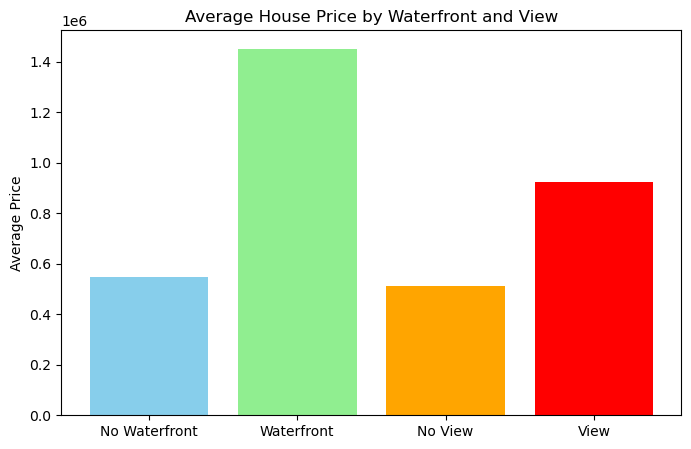

In [3]:

nan_count = df.isna().sum()

zero_count = (df == 0).sum()


check_df = pd.DataFrame({
    "NaN_count": nan_count,
    "Zero_count": zero_count
})

print(check_df)



mean_no_water = df.loc[df["waterfront"] == 0, "price"].mean()
mean_yes_water = df.loc[df["waterfront"] != 0, "price"].mean()
print("Average price (no waterfront):", mean_no_water)
print("Average price (with waterfront):", mean_yes_water)


mean_no_view = df.loc[df["view"] == 0, "price"].mean()
mean_yes_view = df.loc[df["view"] != 0, "price"].mean()
print("Average price (no view):", mean_no_view)
print("Average price (with view):", mean_yes_view)


labels = ["No Waterfront", "Waterfront", "No View", "View"]
values = [mean_no_water, mean_yes_water, mean_no_view, mean_yes_view]

plt.figure(figsize=(8,5))
plt.bar(labels, values, color=["skyblue", "lightgreen", "orange", "red"])
plt.ylabel("Average Price")
plt.title("Average House Price by Waterfront and View")
plt.show()




In [4]:
df["price"].min()
df["price"].max()
num_zero_price = (df["price"] == 0).sum()

print("Number of houses with price = 0:", num_zero_price)
df = df[df["price"] != 0]
df["price"].mean()


Number of houses with price = 0: 49


557905.8991379443

## Target Variable Transformation

When plotting the distribution of the target variable (`price`), we observed a **long right tail**.  
The skewness test confirmed this, giving a value of approximately **25 >> 1**, which indicates that the data is **highly right-skewed**.  

To address this, we applied a **log(x+1) transformation** in order to:  
- Reduce skewness and variance.  
- Make the distribution closer to normal.  
- Improve the performance of models such as **Linear Regression**, which assume that residuals are normally distributed.  

After the transformation, the distribution of the target variable became much closer to normal, and the skewness test value dropped to **0.3**, indicating that the data is no longer significantly skewed.  


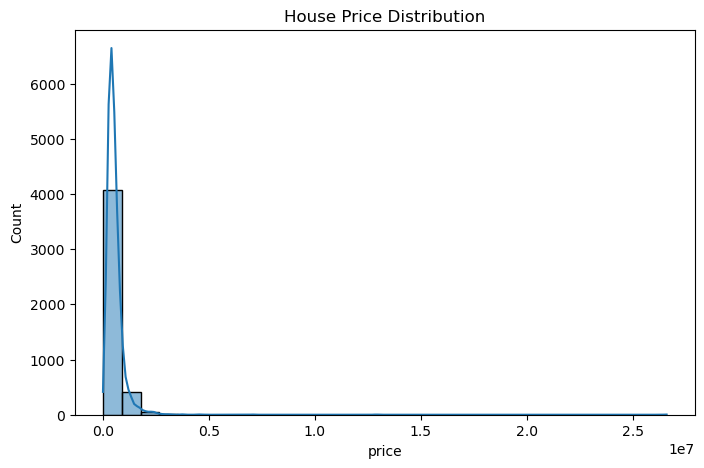

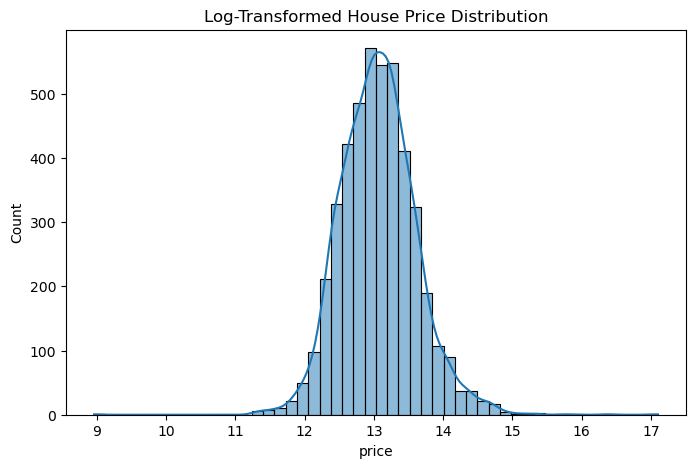

Skewness before : 25.015568709381817
Skewness after 0.329885673237923


In [5]:

y=df["price"]
plt.figure(figsize=(8,5))
sns.histplot(y, bins=30, kde=True)
plt.title("House Price Distribution")
plt.show()
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(y), bins=50, kde=True)
plt.title("Log-Transformed House Price Distribution")
plt.show()
print("Skewness before :", skew(y))
print("Skewness after", skew(np.log1p(y)))


## Date Feature Engineering

From the `date` column, we extracted the **month**, **year**, and **day** information.  

- We found that the dataset only contains data from a single year (**2014**), so the **year** column does not add any useful information and was dropped.  
- The **day** and **day of week** attributes were also dropped, as they did not show meaningful patterns related to house prices.  
- The **month** attribute contained three unique values: **May, June, and July**. From the distribution, we observed that house prices tend to be higher in the **summer months**, suggesting that the month of sale has an influence on prices.  

👉 Therefore, we decided to **keep the month attribute** as a potentially informative predictor.  


month
5    539930.650557
6    554070.841774
7    619148.620032
Name: price, dtype: float64


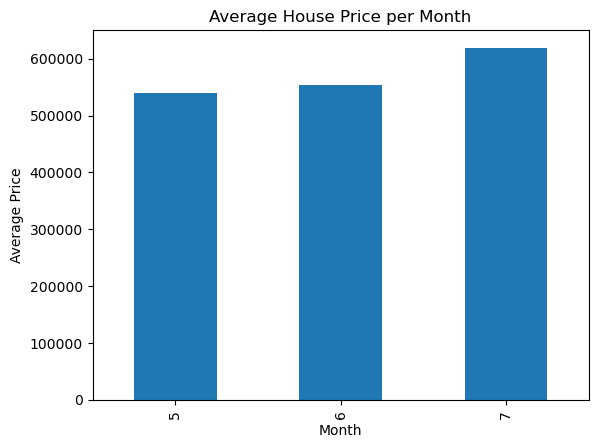

dayofweek
0    553813.386478
1    550701.403501
2    549043.647144
3    581888.831295
4    550237.149665
5    611788.000000
6    581816.562500
Name: price, dtype: float64


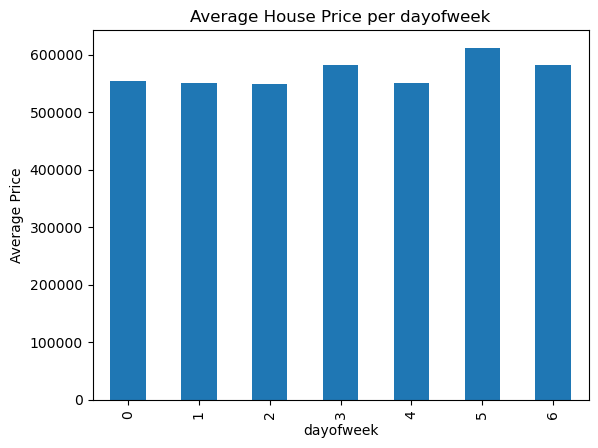

In [143]:
df["date"].nunique()
df["date"] = pd.to_datetime(df["date"])   


df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["dayofweek"] = df["date"].dt.dayofweek  
df = df.drop(columns=["date"])
df["year"].nunique()
df["dayofweek"].nunique()
mean_price_per_month = df.groupby("month")["price"].mean()

print(mean_price_per_month)


mean_price_per_month.plot(kind="bar")
plt.xlabel("Month")
plt.ylabel("Average Price")
plt.title("Average House Price per Month")
plt.show()
mean_price_per_day = df.groupby("dayofweek")["price"].mean()

print(mean_price_per_day)


mean_price_per_day.plot(kind="bar")
plt.xlabel("dayofweek")
plt.ylabel("Average Price")
plt.title("Average House Price per dayofweek")
plt.show()




## Categorical Feature Analysis

- **Country**: This attribute contains only one unique value (`USA`). Since it does not provide any variability, it was dropped.  

- **Street**: There are **4,476 distinct values**, which means most houses have a unique street. This makes `street` act more like an **ID** rather than a meaningful predictor. Therefore, it was dropped.  

- **City & Zipcode**:  
  - Both attributes appear informative, as certain cities and zip codes are associated with higher house prices. For example, houses in **Medina** are generally more expensive than those in **Clyde Hill**.  
  
  - Keeping both `city` and `zipcode` may introduce **multicollinearity issues**, especially after applying one-hot encoding for categorical variables in models like **Linear Regression**.  

👉 For this reason, we decided to **keep only `zipcode`** and drop the `city` attribute.  
👉 The chosen categorical attribute (`statezip`) was then **encoded using one-hot encoding** to make it suitable for modeling.
👉 The chosen categorical attribute (`month`) was then **encoded using one-hot encoding** to make avoid the label encoding since there is no ordinal order. 


In [144]:



df.drop("year",axis=1,inplace=True)
df.drop("day",axis=1,inplace=True)
df.drop("dayofweek",axis=1,inplace=True)

print(df["country"].nunique())
df.drop("country",axis=1,inplace=True)


1


In [145]:
print(df["street"].nunique())

most_common_value = df["street"].mode()[0]
count = (df["street"] == most_common_value).sum()

print("Most common value:", most_common_value)
print("Count:", count)
df.drop("street",inplace=True,axis=1)

4476
Most common value: 2520 Mulberry Walk NE
Count: 4


Number of unique zip codes: 77
Most common zip code: WA 98103
Count: 148
statezip
WA 98039    2.046559e+06
WA 98004    1.372758e+06
WA 98040    1.178638e+06
WA 98109    1.049846e+06
WA 98112    1.001604e+06
                ...     
WA 98032    2.613425e+05
WA 98168    2.557383e+05
WA 98288    2.330000e+05
WA 98002    2.299344e+05
WA 98047    2.252333e+05
Name: price, Length: 77, dtype: float64


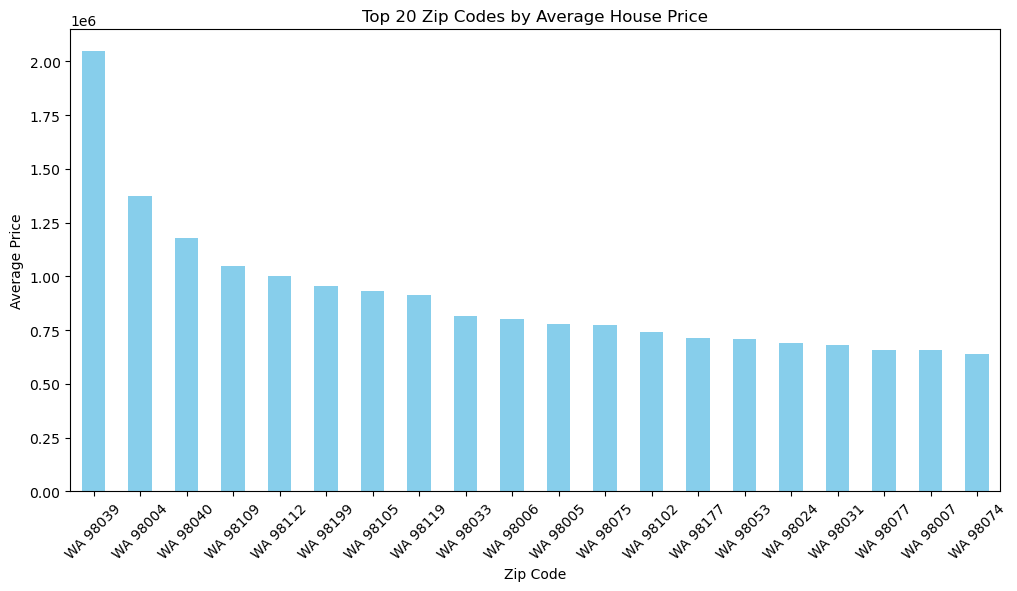

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,...,statezip_WA 98168,statezip_WA 98177,statezip_WA 98178,statezip_WA 98188,statezip_WA 98198,statezip_WA 98199,statezip_WA 98288,statezip_WA 98354,month_6,month_7
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,...,False,False,False,False,False,False,False,False,False,False
1,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,...,False,False,False,False,False,False,False,False,False,False
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,...,False,False,False,False,False,False,False,False,False,False
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,...,False,False,False,False,False,False,False,False,False,False
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,...,False,False,False,False,False,False,False,False,False,False


In [146]:

df.head()


print("Number of unique zip codes:", df["statezip"].nunique())


most_common_value = df["statezip"].mode()[0]
count = (df["statezip"] == most_common_value).sum()
print("Most common zip code:", most_common_value)
print("Count:", count)


mean_price_zip = df.groupby("statezip")["price"].mean().sort_values(ascending=False)
print(mean_price_zip)


plt.figure(figsize=(12,6))
mean_price_zip.head(20).plot(kind="bar", color="skyblue")
plt.xlabel("Zip Code")
plt.ylabel("Average Price")
plt.title("Top 20 Zip Codes by Average House Price")
plt.xticks(rotation=45)
plt.show()

df = pd.get_dummies(df, columns=["statezip"], drop_first=True)
df = pd.get_dummies(df, columns=["month"], drop_first=True)
df.head()

Number of unique cities: 44
Most common city: Seattle
Count: 1561
city
Medina                 2.046559e+06
Clyde Hill             1.615711e+06
Yarrow Point           1.194838e+06
Mercer Island          1.178638e+06
Bellevue               8.622551e+05
Beaux Arts Village     7.450000e+05
Sammamish              7.029858e+05
Fall City              6.926818e+05
Redmond                6.676495e+05
Newcastle              6.660467e+05
Kirkland               6.515836e+05
Woodinville            6.149121e+05
Issaquah               5.993689e+05
Seattle                5.842949e+05
Preston                5.624500e+05
Snoqualmie             5.518504e+05
Normandy Park          5.366044e+05
Snoqualmie Pass        5.250000e+05
Ravensdale             5.140714e+05
Carnation              5.087520e+05
Bothell                4.814419e+05
Lake Forest Park       4.748559e+05
Vashon                 4.725569e+05
Kenmore                4.543786e+05
Kent                   4.418810e+05
Inglewood-Finn Hill    4.2500

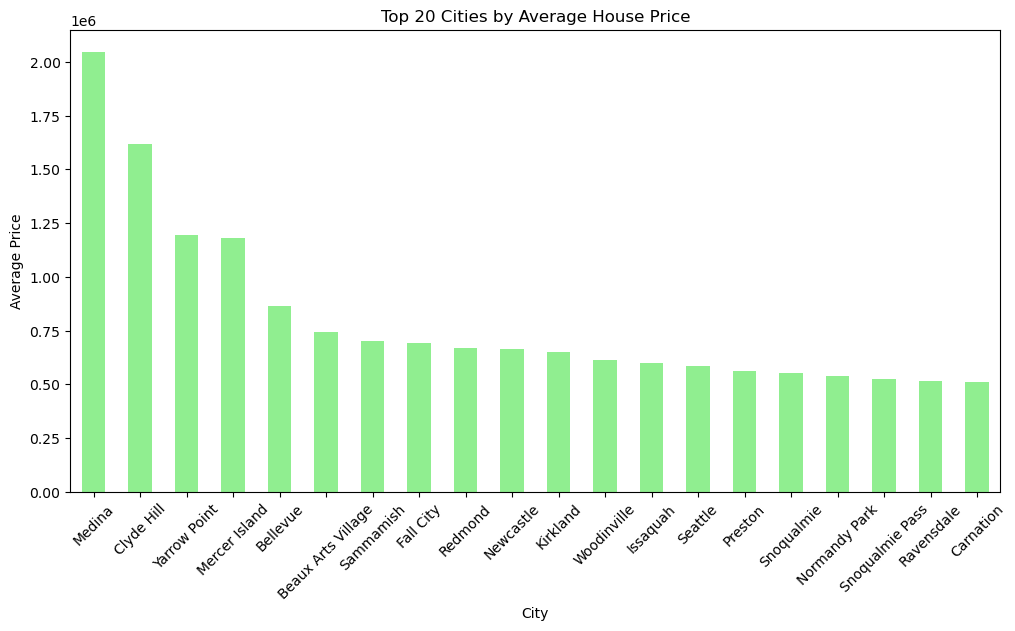

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,...,statezip_WA 98168,statezip_WA 98177,statezip_WA 98178,statezip_WA 98188,statezip_WA 98198,statezip_WA 98199,statezip_WA 98288,statezip_WA 98354,month_6,month_7
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,...,False,False,False,False,False,False,False,False,False,False
1,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,...,False,False,False,False,False,False,False,False,False,False
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,...,False,False,False,False,False,False,False,False,False,False
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,...,False,False,False,False,False,False,False,False,False,False
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,...,False,False,False,False,False,False,False,False,False,False


In [147]:


print("Number of unique cities:", df["city"].nunique())


most_common_city = df["city"].mode()[0]
count_city = (df["city"] == most_common_city).sum()
print("Most common city:", most_common_city)
print("Count:", count_city)


mean_price_city = df.groupby("city")["price"].mean().sort_values(ascending=False)
print(mean_price_city)


plt.figure(figsize=(12,6))
mean_price_city.head(20).plot(kind="bar", color="lightgreen")
plt.xlabel("City")
plt.ylabel("Average Price")
plt.title("Top 20 Cities by Average House Price")
plt.xticks(rotation=45)
plt.show()


df.drop("city",inplace=True,axis=1)
df.head()

count    4.551000e+03
mean     5.579059e+05
std      5.639299e+05
min      7.800000e+03
25%      3.262643e+05
50%      4.650000e+05
75%      6.575000e+05
max      2.659000e+07
Name: price, dtype: float64
count    4551.000000
mean       13.064965
std         0.542788
min         8.962007
25%        12.695466
50%        13.049795
75%        13.396202
max        17.096046
Name: price, dtype: float64
Skewness: 0.329885673237923


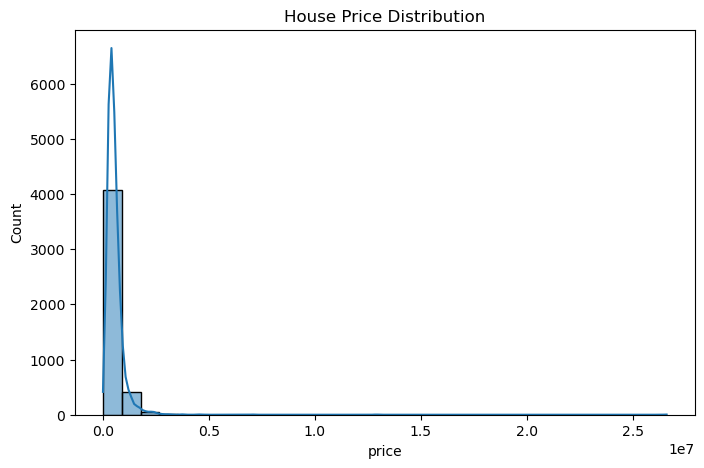

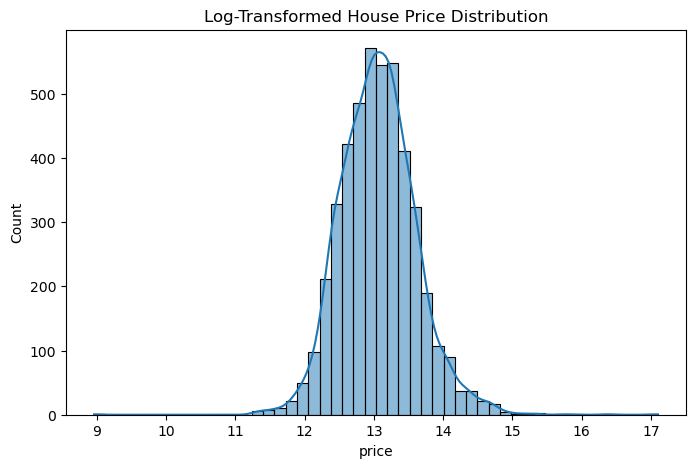

Skewness: 0.329885673237923


In [148]:
X = df.drop("price", axis=1) 
y = df["price"]

print(y.describe())
y_transformed=np.log1p(y)
print(y_transformed.describe())


print("Skewness:", skew(y_transformed))


plt.figure(figsize=(8,5))
sns.histplot(y, bins=30, kde=True)
plt.title("House Price Distribution")
plt.show()
plt.figure(figsize=(8,5))
sns.histplot(y_transformed, bins=50, kde=True)
plt.title("Log-Transformed House Price Distribution")
plt.show()
print("Skewness:", skew(y_transformed))


## Model Evaluation and Results  

After applying a **Linear Regression model**, we obtained an **R² score of 0.80 on the training set** and **0.75 on the testing set**.  
This indicates that the model **does not overfit** and also **does not underfit**, since an R² of 0.75 is considered a good performance for this type of task.  

The **RMSE (Root Mean Squared Error)** was approximately **714,176**, which is a reasonable result for a classic machine learning model like Linear Regression.  

We then applied a **Ridge Regression model**, which produced almost identical results to the Linear Regression model. This further supports the conclusion that the first model was **not overfitting**.  

Finally, we tested an **XGBoost Regressor**, which gave us a **higher training score** but a **lower testing score** compared to Linear Regression. This suggests that XGBoost may have captured more **noise** from the data, leading to a degree of **overfitting**. However, with proper **hyperparameter tuning**, XGBoost has the potential to improve the results further.  


In [149]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y_transformed, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = LinearRegression()
model.fit(X_train_scaled, y_train)
print("Train R²:", model.score(X_train_scaled, y_train))
print("Test R²:", model.score(X_test_scaled, y_test))
# RMSE
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_test_pred)

# RMSE in original price units
rmse_test_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
print("Test RMSE (original price):", rmse_test_original)



Train R²: 0.8059211004255169
Test R²: 0.753649104155262
Test RMSE (original price): 714175.9699405604


In [150]:

model = Ridge(alpha=1.0)  # alpha controls regularization strength
model.fit(X_train_scaled, y_train)

# Evaluate
print("Train R²:", model.score(X_train_scaled, y_train))
print("Test R²:", model.score(X_test_scaled, y_test))

Train R²: 0.8059168449583449
Test R²: 0.753591502810566


In [151]:
# Initialize XGBoost
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Evaluate R²
print("Train R²:", model.score(X_train, y_train))
print("Test R²:", model.score(X_test, y_test))

Train R²: 0.8577800874574395
Test R²: 0.7082029633356222
